In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

from lib.plotting import configure_matplotlib, sized_fig

configure_matplotlib()

In [5]:
min_samples = 5
min_cluster_size = min_samples
data = np.load("data.npy")

## Check API and plots

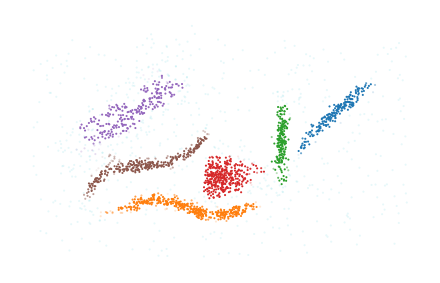

In [ ]:
from plscan import PLSCAN, api

c = PLSCAN(min_samples=5, metric="euclidean").fit(data)
sized_fig()
plt.scatter(
    *data.T,
    c=c.labels_ % 10,
    alpha=np.maximum(0.1, c.probabilities_),
    s=1,
    linewidth=0,
    cmap="tab10",
)
plt.axis("off")
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.show()

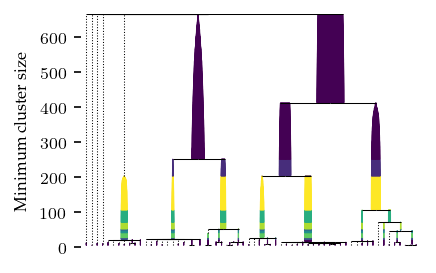

In [7]:
sized_fig()
c.leaf_tree_.plot(leaf_separation=0.1, colorbar=False)
plt.subplots_adjust(left=0.17, top=0.96, bottom=0.04, right=1)
plt.savefig("images/leaf_tree.pdf", pad_inches=0)
plt.show()

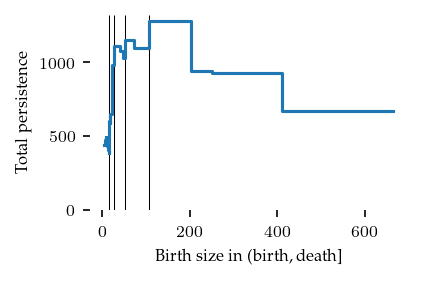

In [ ]:
layers = c.cluster_layers(
    # min_size=16.0, # min cluster size threshold
    # max_size=80,   # max cluster size threshold
    # height=600,    # persistence threshold
    # threshold=25,  # persistence difference between the peak and neighbors
    n_peaks=4,  # keep only the n most persistent peaks after all thresholds
)

sized_fig()
c.persistence_trace_.plot()
plt.vlines(list(zip(*layers))[0], *plt.ylim(), color="k", linewidth=0.5, zorder=1)
# plt.xlim([0, 125])
plt.show()

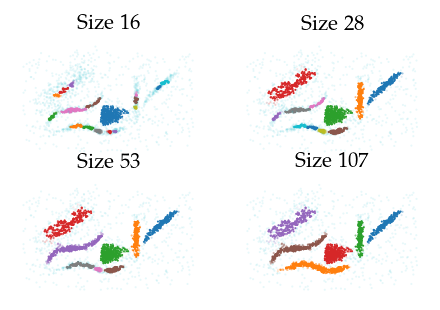

In [9]:
n_rows = int(np.ceil(np.sqrt(len(layers))))
n_cols = n_rows
sized_fig()
for i, (size, labels, probs) in enumerate(layers):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.scatter(
        *data.T,
        c=labels % 10,
        alpha=np.maximum(0.1, probs),
        s=1,
        linewidth=0,
        cmap="tab10",
    )
    plt.title(f"Size {int(size)}")
    plt.axis("off")
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
plt.show()

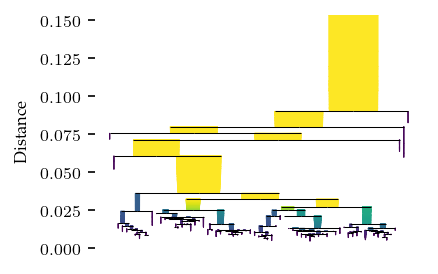

In [10]:
sized_fig()
c.condensed_tree_.plot(leaf_separation=0.15, distance_ranks=False, colorbar=False)
plt.subplots_adjust(left=0.2, top=0.96, bottom=0.04, right=1)
plt.savefig("images/condensed_tree.pdf", pad_inches=0)
plt.show()

## Timing: 

Check individual function times, used for manual regression testing (for now). 

In [11]:
from plscan.api import *

# Define all internal variables so we can time each function separately
num_points = data.shape[0]
selected_clusters = c.selected_clusters_
trace = c._persistence_trace
sorted_mst = c._minimum_spanning_tree
condensed_tree = c._condensed_tree
leaf_tree = c._leaf_tree
linkage_tree = c._linkage_tree
sample_weights = None
metric = c.metric
min_samples = c.min_samples
min_cluster_size = float(min_samples)
max_cluster_size = c.max_cluster_size
knn = NearestNeighbors(n_neighbors=8).fit(data).kneighbors()
graph = knn_to_csr(*knn)
graph = SparseGraph(graph.data, graph.indices, graph.indptr)
core_distances = c.core_distances_
mut_graph = compute_mutual_reachability(graph, core_distances)
spanning_tree = extract_spanning_forest(mut_graph)

In [13]:
%%timeit
mst, neighbors, core_dists = compute_mutual_spanning_tree(
    data, min_samples=min_samples, metric=metric
)

1.23 ms ± 10.9 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [14]:
%%timeit
graph = knn_to_csr(*knn)
SparseGraph(graph.data, graph.indices, graph.indptr)

35.8 μs ± 2.42 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [15]:
%%timeit
extract_core_distances(graph, min_samples=min_samples, is_sorted=True)

4.66 μs ± 576 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [16]:
%%timeit
compute_mutual_reachability(graph, core_distances)

29.2 μs ± 723 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [17]:
%%timeit
extract_spanning_forest(mut_graph)

148 μs ± 5.3 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [18]:
%%timeit
order = np.argsort(spanning_tree.distance)
SpanningTree(
    parent=spanning_tree.parent[order],
    child=spanning_tree.child[order],
    distance=spanning_tree.distance[order],
)

48.9 μs ± 260 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [19]:
%%timeit
linkage_tree = compute_linkage_tree(
    sorted_mst, num_points, sample_weights=sample_weights
)

19.4 μs ± 378 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [ ]:
%%timeit
compute_condensed_tree(
    linkage_tree,
    sorted_mst,
    num_points,
    min_cluster_size=min_cluster_size,
    sample_weights=sample_weights,
)

8.93 μs ± 160 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [ ]:
%%timeit
compute_leaf_tree(condensed_tree, num_points, min_cluster_size=min_cluster_size)

1.69 μs ± 8.1 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [22]:
%%timeit
compute_bi_persistence(leaf_tree, condensed_tree, num_points)

33.9 μs ± 1.3 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [ ]:
%%timeit
compute_size_persistence(leaf_tree)

2.27 μs ± 10.5 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [24]:
%%timeit
most_persistent_clusters(leaf_tree, trace)

6.04 μs ± 39.5 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [25]:
%%timeit
compute_cluster_labels(leaf_tree, condensed_tree, selected_clusters, num_points)

3.4 μs ± 57.5 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
